In [ ]:
#Importamos librerías que nos sean útiles para el trabajo
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib.ticker import ScalarFormatter

#Configuramos la calidad de imagen
plt.rcParams["figure.dpi"] = 96

In [ ]:
#Leemos el archivo a trabajar
data1 = pd.read_csv('A_INSCRITOS_PUNTAJES_PDT_2022_PUB_MRUN.csv', sep=';')

In [ ]:
#Seleccionamos las columnas de mayor utilidad para efectos prácticos
new_col = ['PROM_CM_ACTUAL', 'CODIGO_REGION_EGRESO', 'NOMBRE_COMUNA_EGRESO', 'CODIGO_COMUNA_EGRESO']
data2 = data1[new_col]

In [ ]:
#Seleccionamos las comunas de la región metropolitana, ya que se trabajará en Santiago
df_rm = data2[data2['CODIGO_REGION_EGRESO'] == 13]

<Axes: >

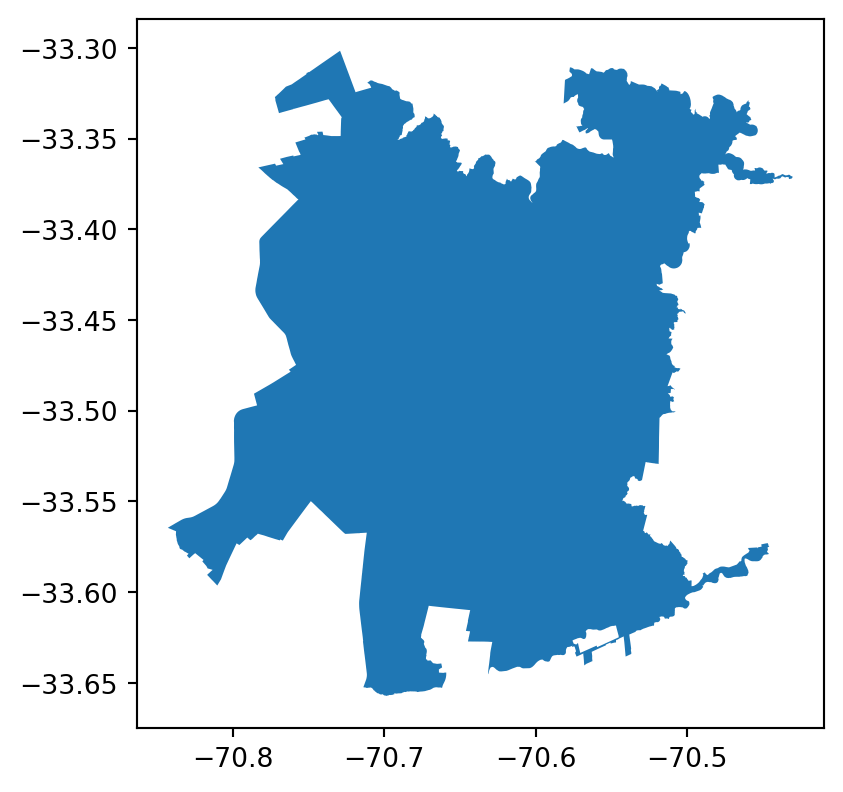

In [ ]:
#Abrimos nuestro geopanda con el mapa de Santiago
urban_stgo = gpd.read_file('urban_stgo_border.shp')
urban_stgo = urban_stgo.set_crs('EPSG:4326')
urban_stgo = urban_stgo.to_crs('EPSG:4326')
urban_stgo.plot()

In [ ]:
#Con el archivo json buscamos los límites de cada comuna para ubicar las coordenadas
comunas = gpd.read_file('urban_comunas.json')

In [ ]:
#Cambiamos los valores a números para trabajar con mayor facilidad.
comunas['REGION'] = comunas['REGION'].astype(int)
comunas['PROVINCIA'] = comunas['PROVINCIA'].astype(int)
comunas['COMUNA'] = comunas['COMUNA'].astype(int)

<Axes: >

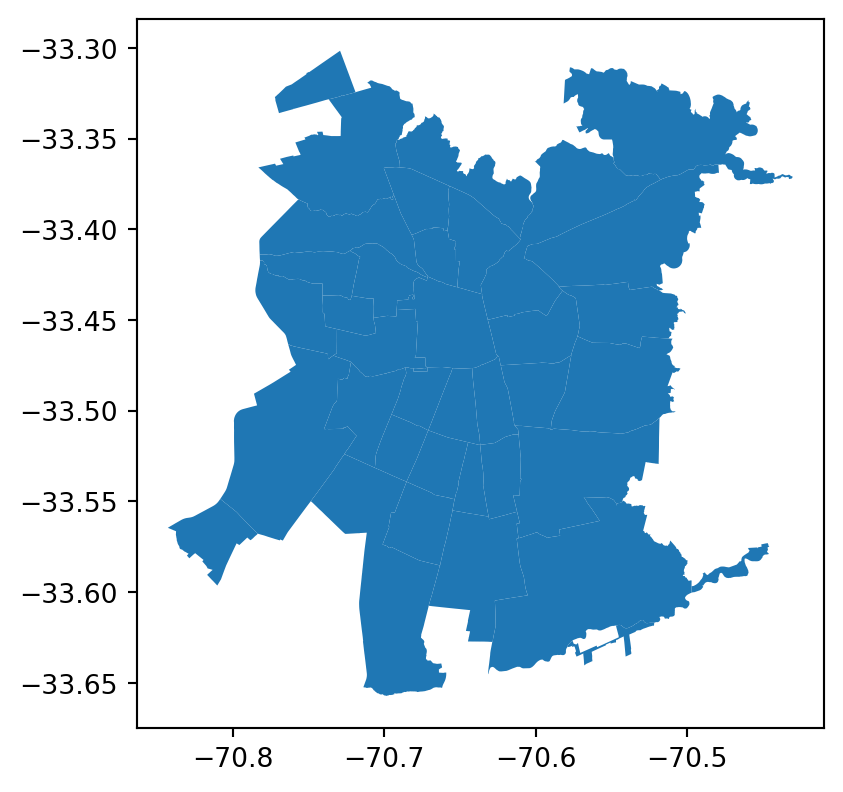

In [ ]:
#Realizar la intersección
urban_comunas = gpd.overlay(comunas, urban_stgo, how='intersection')

#Hacer el gráfico de la intersección
urban_comunas.plot()

In [ ]:
df_rm['CODIGO_COMUNA_EGRESO'] = df_rm['CODIGO_COMUNA_EGRESO'].astype(int)
#Fusionamos los DataFrames utilizando las columnas 'COMUNA' y 'CODIGO_COMUNA_EGRESO'
urban_data = urban_comunas.merge(df_rm, how='inner', left_on='COMUNA', right_on='CODIGO_COMUNA_EGRESO')

<ipython-input-9-ba5a473b8457>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rm['CODIGO_COMUNA_EGRESO'] = df_rm['CODIGO_COMUNA_EGRESO'].astype(int)


In [ ]:
#Eliminar filas sin datos y con 0
urban_data['PROM_CM_ACTUAL'] = pd.to_numeric(urban_data['PROM_CM_ACTUAL'], errors='coerce')
urban_data = urban_data[urban_data['PROM_CM_ACTUAL'] != 0]
urban_data

,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,SHAPE_Leng,SHAPE_Area,geometry,PROM_CM_ACTUAL,CODIGO_REGION_EGRESO,NOMBRE_COMUNA_EGRESO,CODIGO_COMUNA_EGRESO
0,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,0.720176,0.019124,"POLYGON ((-70.78216 -33.41714, -70.78215 -33.4...",NaN,13,PUDAHUEL,13124
3,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,0.720176,0.019124,"POLYGON ((-70.78216 -33.41714, -70.78215 -33.4...",417.0,13,PUDAHUEL,13124
4,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,0.720176,0.019124,"POLYGON ((-70.78216 -33.41714, -70.78215 -33.4...",NaN,13,PUDAHUEL,13124
6,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,0.720176,0.019124,"POLYGON ((-70.78216 -33.41714, -70.78215 -33.4...",NaN,13,PUDAHUEL,13124
7,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,0.720176,0.019124,"POLYGON ((-70.78216 -33.41714, -70.78215 -33.4...",469.0,13,PUDAHUEL,13124
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96832,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13101,SANTIAGO,0.243050,0.002244,"POLYGON ((-70.66457 -33.42853, -70.66457 -33.4...",538.0,13,SANTIAGO,13101
96837,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13101,SANTIAGO,0.243050,0.002244,"POLYGON ((-70.66457 -33.42853, -70.66457 -33.4...",368.0,13,SANTIAGO,13101
96839,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13101,SANTIAGO,0.243050,0.002244,"POLYGON ((-70.66457 -33.42853, -70.66457 -33.4...",NaN,13,SANTIAGO,13101
96841,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13101,SANTIAGO,0.243050,0.002244,"POLYGON ((-70.66457 -33.42853, -70.66457 -33.4...",524.0,13,SANTIAGO,13101


In [ ]:
#Calculamos el promedio por comuna para asi trabajar con menos filas y obtener un mejor resultado
#Agrupamos por el valor en la columna COMUNA y calculamos el promedio de PROM_CM_ACTUAL
nuevo_df = urban_data.groupby('COMUNA').agg({'PROM_CM_ACTUAL': 'mean',
                                             'NOM_COMUNA': 'first',
                                             }).reset_index()

#Renombrar la columna 'PROM_CM_ACTUAL' a 'PROM_CM_COMUNA'
nuevo_df = nuevo_df.rename(columns={'PROM_CM_ACTUAL': 'PROMEDIO_CM_COMUNA'})
nuevo_df

,COMUNA,PROMEDIO_CM_COMUNA,NOM_COMUNA
0,13101,519.025563,SANTIAGO
1,13102,496.769452,CERRILLOS
2,13103,461.515625,CERRO NAVIA
3,13104,471.393939,CONCHALÍ
4,13105,496.329621,EL BOSQUE
5,13106,491.112696,ESTACIÓN CENTRAL
6,13107,551.755102,HUECHURABA
7,13108,488.785824,INDEPENDENCIA
8,13109,486.800316,LA CISTERNA
9,13110,514.421306,LA FLORIDA


In [ ]:
#Fusionamos dataframes
urban_data1 = urban_comunas.merge(nuevo_df, how='inner', left_on='COMUNA', right_on='COMUNA')

In [ ]:
#Calculamos los límites de los intervalos para 5 bins
bins = np.linspace(urban_data1['PROMEDIO_CM_COMUNA'].min(), nuevo_df['PROMEDIO_CM_COMUNA'].max(), 6)  #5 bins, 6 límites

labels = []

for i in range(len(bins) - 1):
    start = int(bins[i])  # Inicio del intervalo
    end = int(bins[i+1])  # Fin del intervalo
    label = f"{start}-{end}"  # Crear la etiqueta como un rango
    labels.append(label)  # Añadir la etiqueta a la lista

urban_data.loc[:, 'Promedio_CATT'] = pd.cut(nuevo_df['PROMEDIO_CM_COMUNA'], bins=bins, labels=labels, include_lowest=True)
labels

['456-489', '489-521', '521-553', '553-585', '585-617']

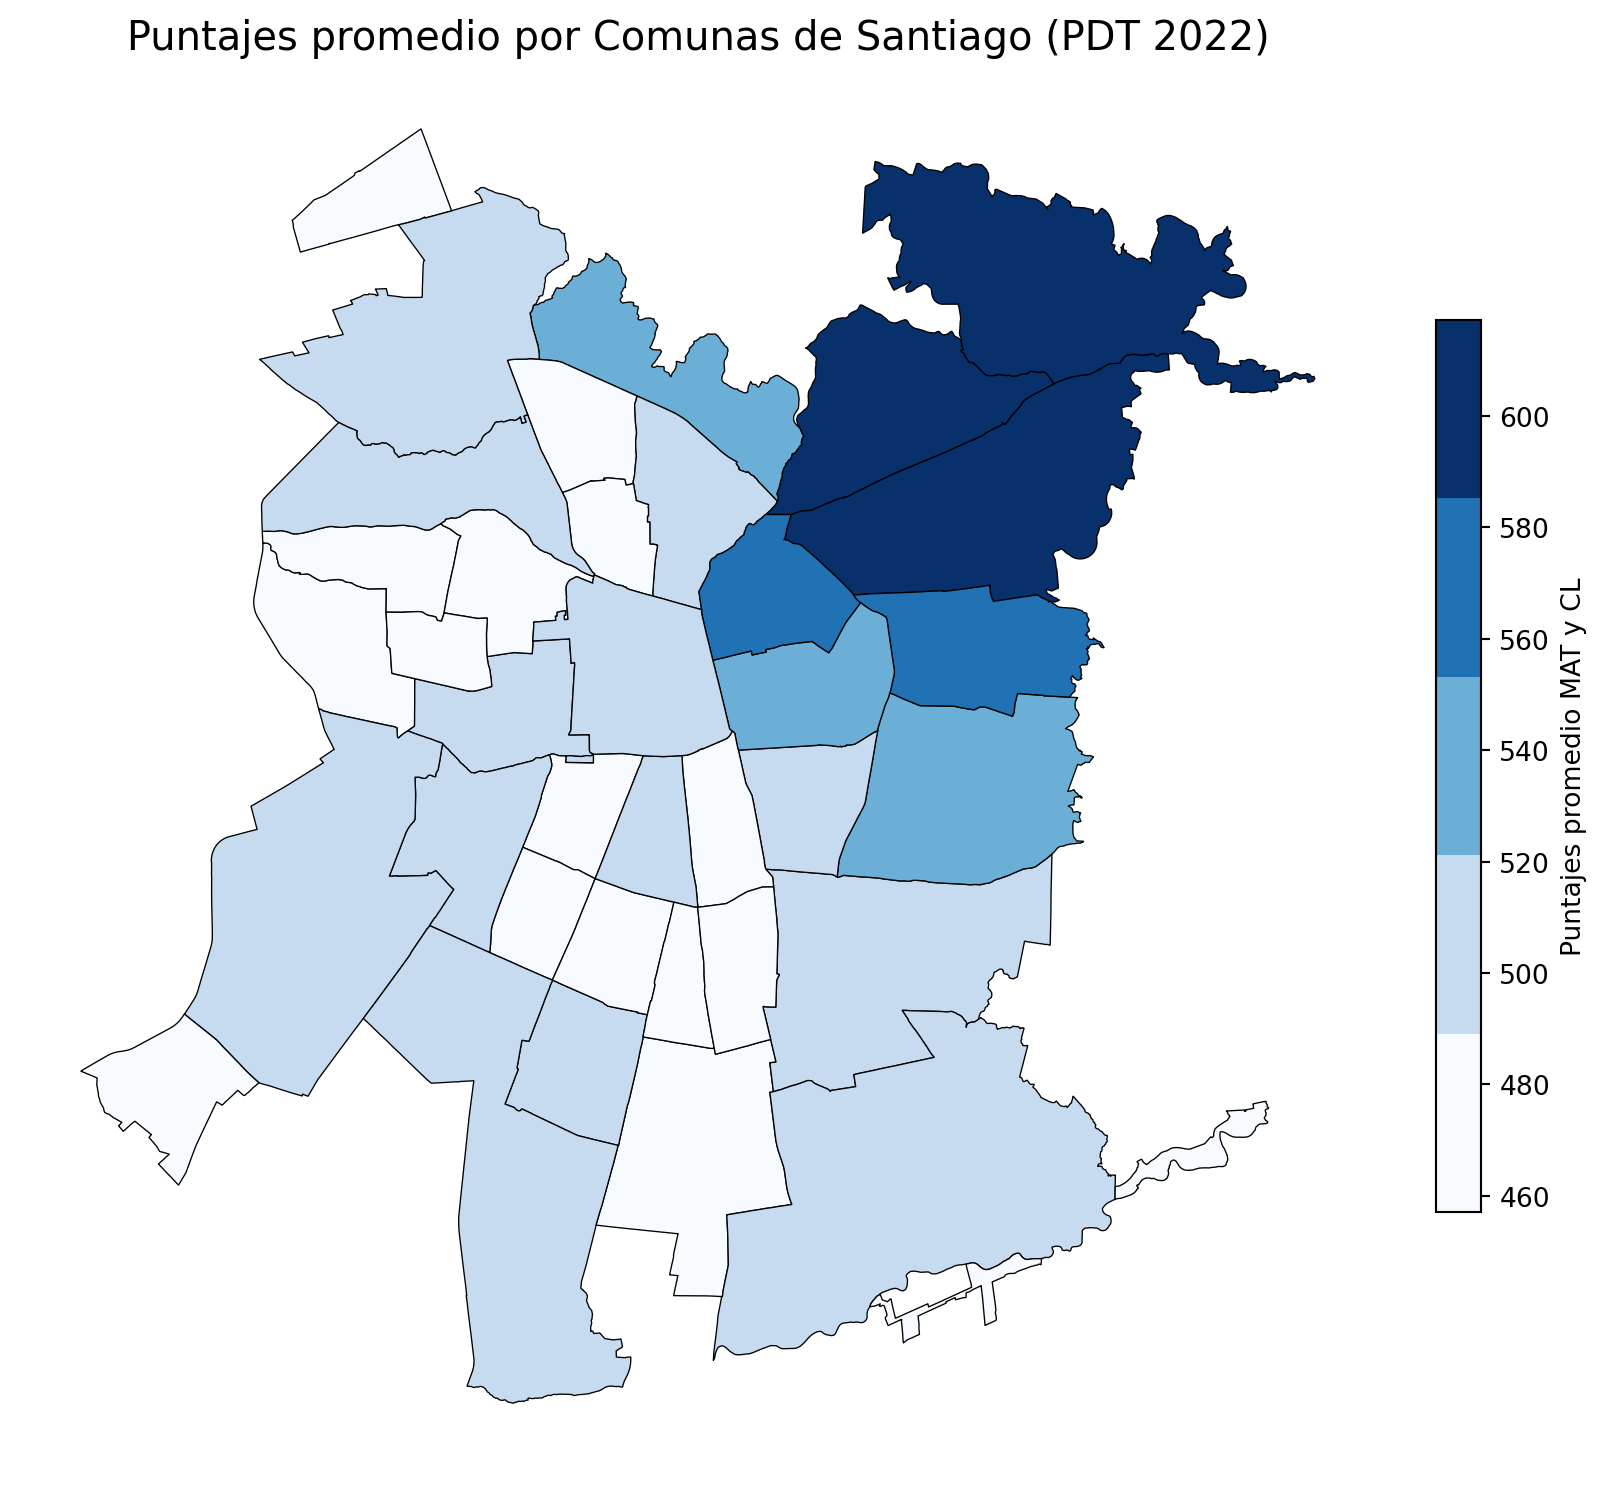

In [ ]:
#Creamos una paleta de colores
cmap = plt.get_cmap('Blues', 5)

#Dibujamos el gráfico de cloropletas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
urban_data1.plot(column='PROMEDIO_CM_COMUNA', ax=ax, cmap=cmap, edgecolor='black', linewidth=0.5)

#Agregamos una leyenda con título
cbar = plt.colorbar(ax.collections[0], ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("Puntajes promedio MAT y CL")

#Ajustamos la ubicación de la leyenda
plt.subplots_adjust(bottom=0.15)

#Agregamos título y ajustes adicionales
ax.set_title("Puntajes promedio por Comunas de Santiago (PDT 2022)", fontsize=15)
ax.set_axis_off()

plt.show()

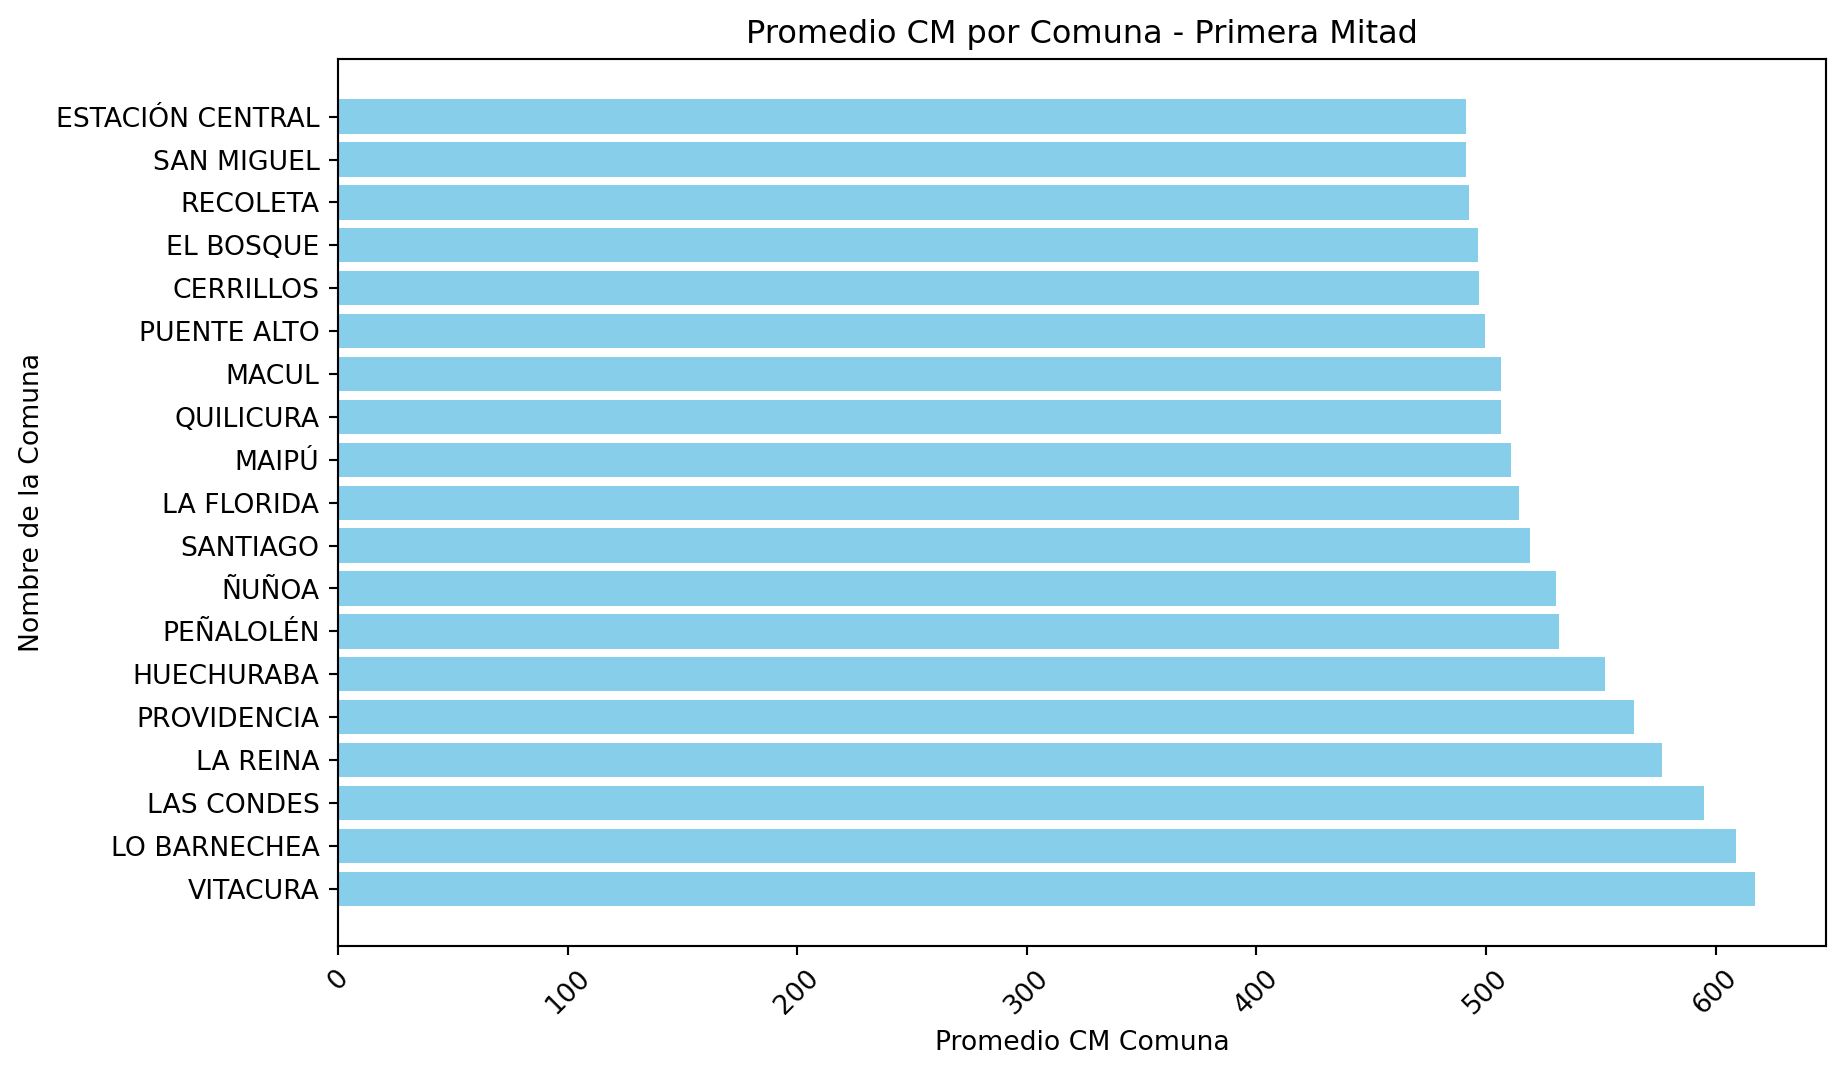

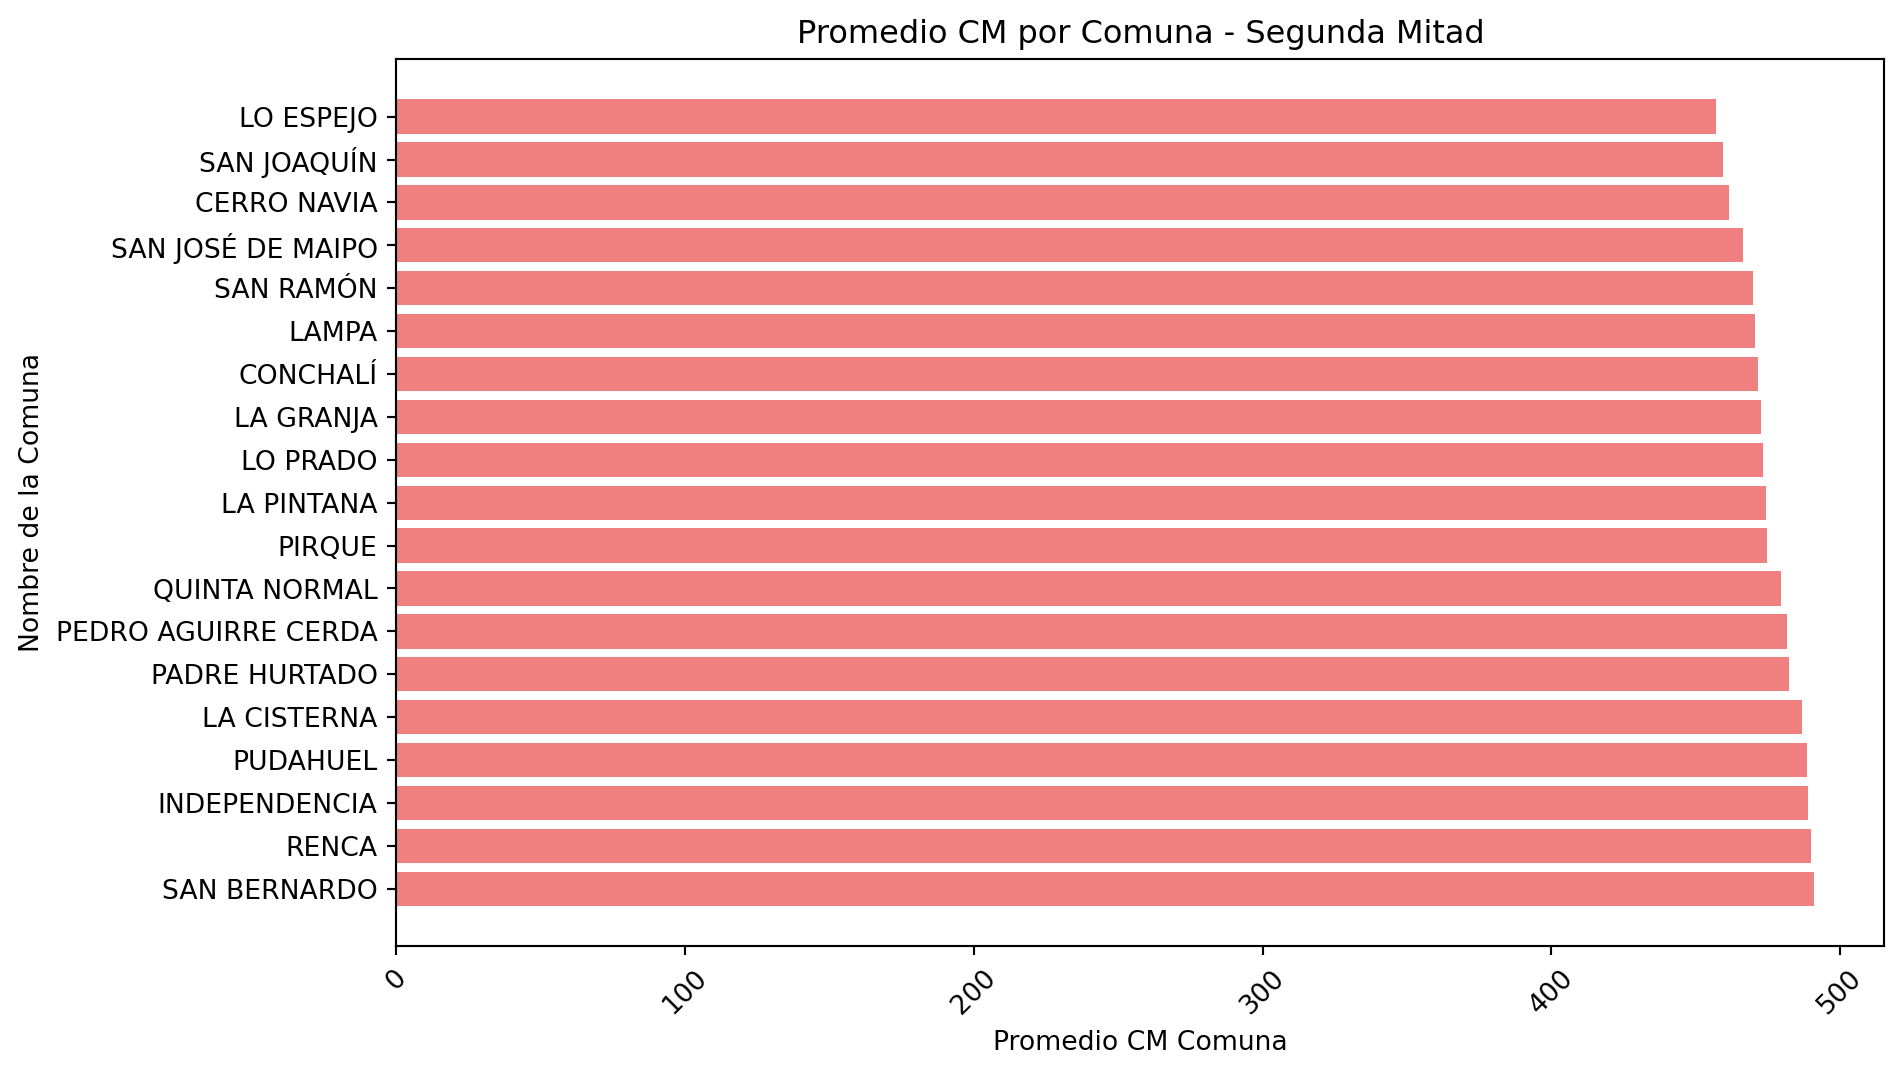

In [ ]:
nuevo_df = nuevo_df.sort_values(by='PROMEDIO_CM_COMUNA', ascending=False)
mitad = len(nuevo_df) // 2
primera_mitad = nuevo_df.iloc[:mitad]
segunda_mitad = nuevo_df.iloc[mitad:]

# Crear el gráfico de barras para la primera mitad
plt.figure(figsize=(10, 6))
plt.barh(primera_mitad['NOM_COMUNA'], primera_mitad['PROMEDIO_CM_COMUNA'], color='skyblue')
plt.title('Promedio CM por Comuna - Primera Mitad')
plt.xlabel('Promedio CM Comuna')
plt.ylabel('Nombre de la Comuna')
plt.xticks(rotation=45)
plt.show()

# Crear el gráfico de barras para la segunda mitad
plt.figure(figsize=(10, 6))
plt.barh(segunda_mitad['NOM_COMUNA'], segunda_mitad['PROMEDIO_CM_COMUNA'], color='lightcoral')
plt.title('Promedio CM por Comuna - Segunda Mitad')
plt.xlabel('Promedio CM Comuna')
plt.ylabel('Nombre de la Comuna')
plt.xticks(rotation=45)
plt.show()

In [ ]:
new_col2 = ['PROM_CM_ACTUAL', 'CODIGO_REGION_EGRESO', 'NOMBRE_COMUNA_EGRESO', 'CODIGO_COMUNA_EGRESO','DEPENDENCIA']
data3 = data1[new_col2]

In [ ]:
data3['PROM_CM_ACTUAL'] = pd.to_numeric(data3['PROM_CM_ACTUAL'], errors='coerce')
data3 = data3[data3['PROM_CM_ACTUAL'] != 0]
data3['DEPENDENCIA'] = pd.to_numeric(data3['DEPENDENCIA'], errors='coerce')
data3 = data3[(data3['DEPENDENCIA'] != 0) & (data3['DEPENDENCIA'].notna())]

<ipython-input-17-71e203914602>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['PROM_CM_ACTUAL'] = pd.to_numeric(data3['PROM_CM_ACTUAL'], errors='coerce')


In [ ]:
promedio_por_dependencia = data3.groupby('DEPENDENCIA').agg({'PROM_CM_ACTUAL': 'mean'}).reset_index()
#Renombrar la columna 'PROM_CM_ACTUAL' a 'PROMEDIO_CM_DEPENDENCIA'
promedio_por_dependencia = promedio_por_dependencia.rename(columns={'PROM_CM_ACTUAL': 'PROMEDIO_CM_DEPENDENCIA'})

#Mostrar el DataFrame resultante
print(promedio_por_dependencia)

   DEPENDENCIA  PROMEDIO_CM_DEPENDENCIA
0          1.0               486.361608
1          2.0               472.310245
2          3.0               498.690546
3          4.0               593.711444
4          5.0               457.595320
5          6.0               458.800136


In [ ]:
promedio_por_dependencia['DEPENDENCIA'] = promedio_por_dependencia['DEPENDENCIA'].replace('', '0')
#Mapear los nombres de las dependencias
dependencia_nombres = {
    1: 'Corporación Municipal',
    2: 'Municipal',
    3: 'Particular Subvencionado',
    4: 'Particular Pagado',
    5: 'Corporación de Administración Delegada',
    6: 'Servicio Local de Educación (SLE)'
}

#Reemplazar los códigos de dependencia por los nombres correspondientes
promedio_por_dependencia['DEPENDENCIA'] = promedio_por_dependencia['DEPENDENCIA'].replace(dependencia_nombres)

#Mostrar el DataFrame resultante
print(promedio_por_dependencia)


                              DEPENDENCIA  PROMEDIO_CM_DEPENDENCIA
0                   Corporación Municipal               486.361608
1                               Municipal               472.310245
2                Particular Subvencionado               498.690546
3                       Particular Pagado               593.711444
4  Corporación de Administración Delegada               457.595320
5       Servicio Local de Educación (SLE)               458.800136


<ipython-input-20-b27481c76989>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(promedio_por_dependencia))  # tab20 es un colormap con 20 colores diferentes


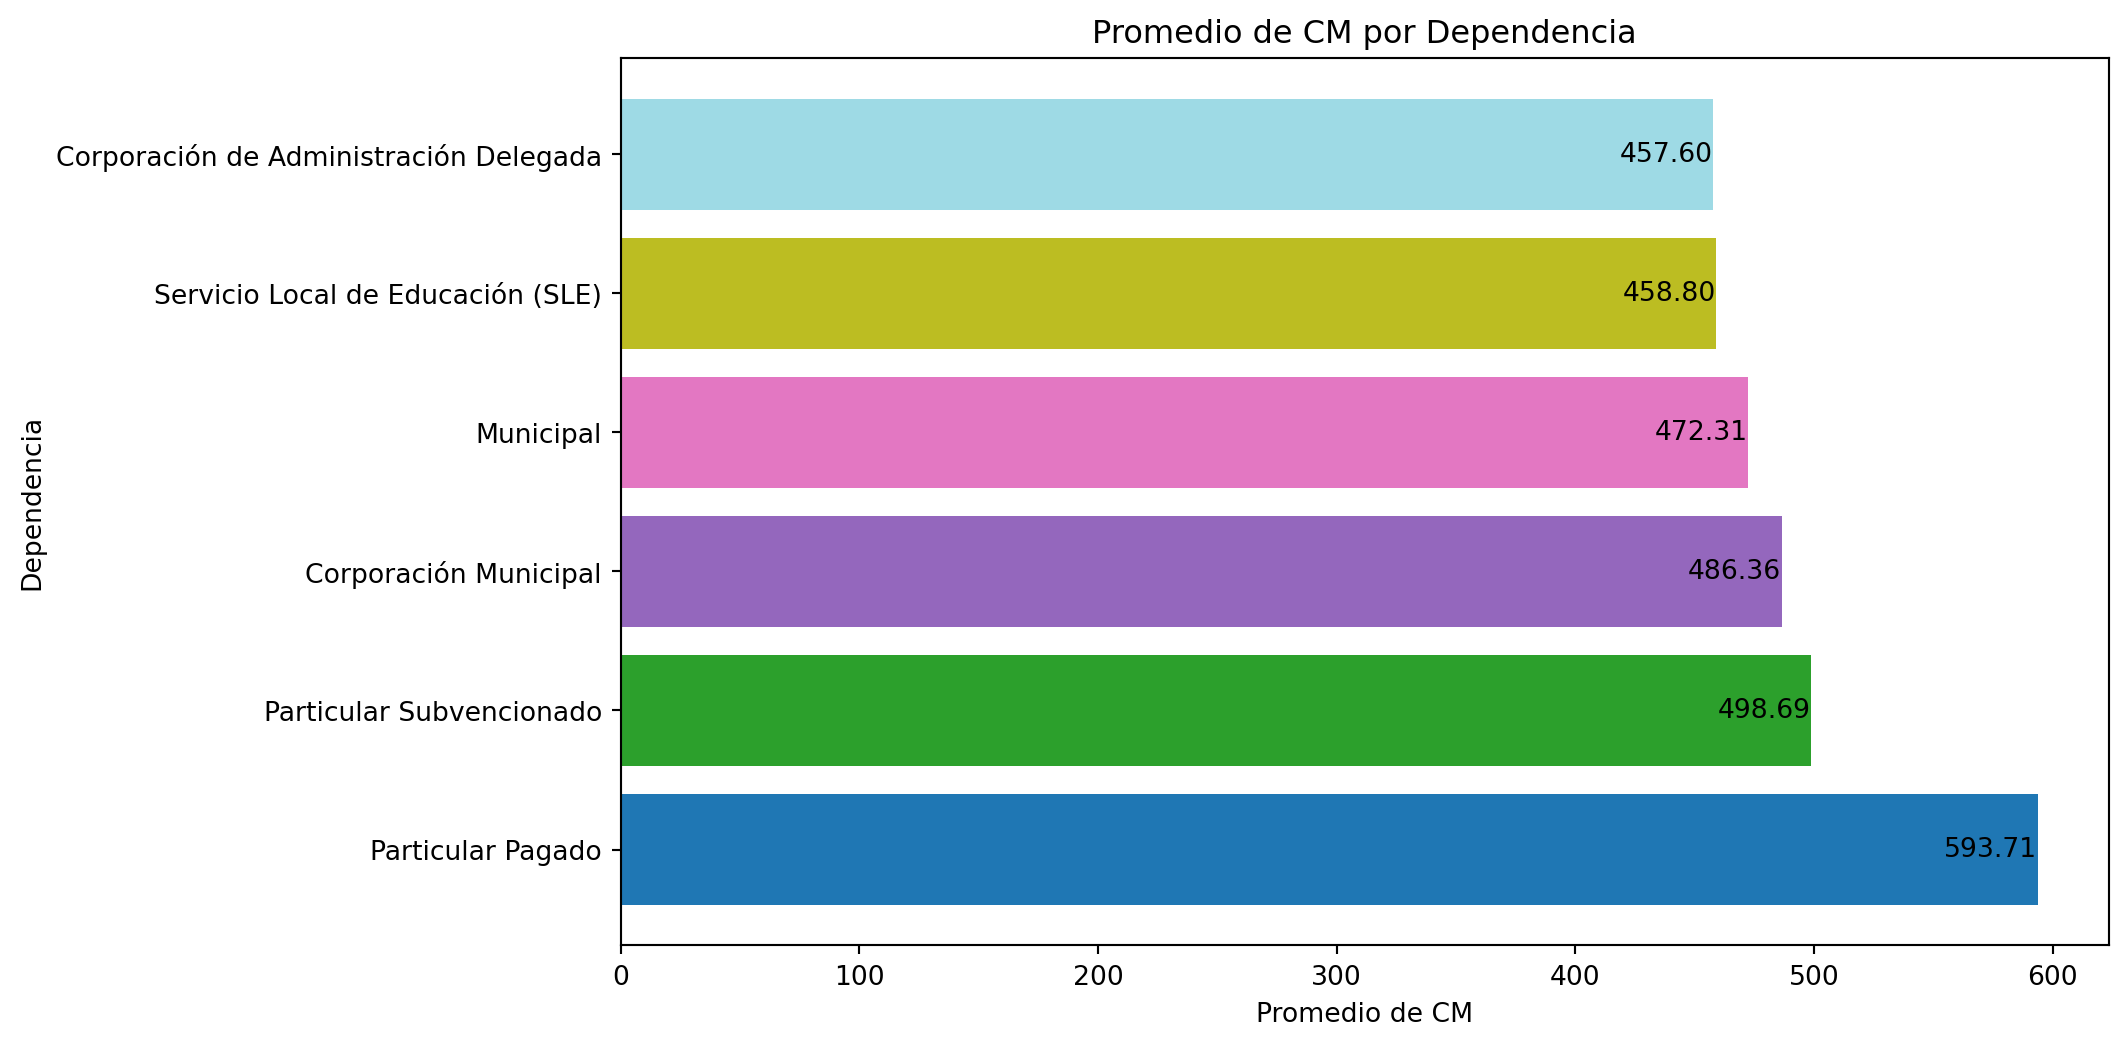

In [ ]:
promedio_por_dependencia = promedio_por_dependencia.sort_values(by='PROMEDIO_CM_DEPENDENCIA', ascending=False)

# Creación de una lista de colores
colors = plt.cm.get_cmap('tab20', len(promedio_por_dependencia))  # tab20 es un colormap con 20 colores diferentes

# Creación del gráfico de barras
plt.figure(figsize=(10, 6))
barras = plt.barh(promedio_por_dependencia['DEPENDENCIA'], promedio_por_dependencia['PROMEDIO_CM_DEPENDENCIA'], color=colors(range(len(promedio_por_dependencia))))

# Añadir los valores dentro de cada barra
for barra in barras:
    plt.text(barra.get_width() - 0.1,  # posición x del texto (ajústala según sea necesario)
             barra.get_y() + barra.get_height() / 2,  # posición y del texto
             f'{barra.get_width():.2f}',  # texto a mostrar con dos decimales
             va='center',  # alineación vertical
             ha='right',  # alineación horizontal
             color='black',  # color del texto
             fontsize=10)  # tamaño de la fuente

plt.title('Promedio de CM por Dependencia')
plt.xlabel('Promedio de CM')
plt.ylabel('Dependencia')
plt.show()